# Table of Contents
 <p>

In [1]:
# based on https://pycbc.org/pycbc/latest/html/inference.html#gw150914-example

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import os
import numpy

import pycbc
from pycbc import (distributions, transforms, fft,
                   opt, psd, scheme, strain, weave)
from pycbc.waveform import generator

from pycbc import __version__
from pycbc import inference
from pycbc.inference import (models, burn_in, option_utils)

In [3]:
import h5py

In [4]:
# setup prior
dist = distributions.Uniform(
    mass1=(32,37),
    mass2=(32,37)
)

jd = distributions.JointDistribution(["mass1","mass2"], dist)

In [5]:
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.waveform.generator import (FDomainDetFrameGenerator,
                                      FDomainCBCGenerator)
seglen = 4
sample_rate = 2048
N = seglen*sample_rate/2+1
fmin = 30.
# variable_params = ['tc']
tsig = 3.1
static_params = {'approximant': 'IMRPhenomD', 'f_lower': fmin,
                 'mass1': 35, 'mass2': 35,
                 'spin1z': 0., 'spin2z': 0., 'ra': 0, 'dec': 0,
                 'polarization': 0, 'distance': 50., 'tc':tsig}

generator = FDomainDetFrameGenerator(
    FDomainCBCGenerator, 0., detectors=['H1'],
    delta_f=1./seglen, **static_params)
signal = generator.generate()
psd = pypsd.aLIGOZeroDetHighPower(N, 1./seglen, 20)
psds = {'H1': psd}
# model = GaussianNoise(variable_params, signal, fmin, psds=psds,
#                       static_params=static_params)
#Set the current position to the coalescence time of the signal:
# model.update(tc=tsig)

In [6]:
model = models.models["gaussian_noise"](
    ["mass1","mass2"],
    signal,
    low_frequency_cutoff = 40,
    prior=jd,
    static_params=static_params,
    psds=psds
)

In [7]:
sampler = inference.sampler.emcee.EmceeEnsembleSampler(
    model,
    nwalkers=20,
    nprocesses=1,
    use_mpi=False)

In [8]:
sampler.setup_output(output_file="inf.hdf", force=True)

In [10]:
sampler.set_target(niterations=500)

In [11]:
sampler.set_initial_conditions()

In [12]:
%%time
sampler.run()

CPU times: user 882 µs, sys: 163 µs, total: 1.05 ms
Wall time: 1.04 ms


In [13]:
sampler.finalize()

In [14]:
f=h5py.File("inf.hdf.checkpoint","r")

In [15]:
list(f)

[u'data', u'sampler_info', u'samples']

In [16]:
list(f['samples'])

[u'H1_cplx_loglr',
 u'H1_optimal_snrsq',
 u'logjacobian',
 u'loglikelihood',
 u'loglr',
 u'logprior',
 u'mass1',
 u'mass2']

In [17]:
f['samples/loglikelihood'].shape

(20, 1000)

In [18]:
f['samples/mass1'].shape

(20, 1000)

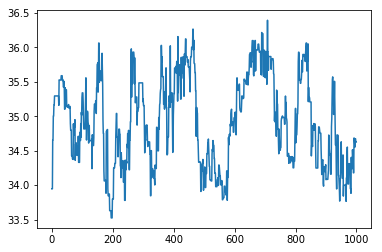

In [19]:
plt.figure()
plt.plot(f['samples/mass1'][0])

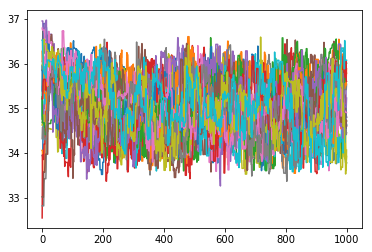

In [20]:
plt.figure()
for i, c in enumerate(f['samples/mass1']):
    plt.plot(c, label=i)

In [21]:
import pycbc

In [22]:
mc1=pycbc.conversions.mchirp_from_mass1_mass2(f['samples/mass1'][:],f['samples/mass2'][:])

In [23]:
mc1.shape

(20, 1000)

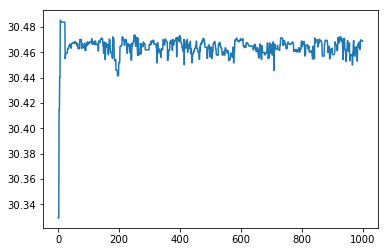

In [25]:
plt.figure()
plt.plot(mc1[0])

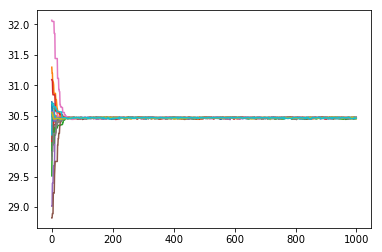

In [26]:
plt.figure()
for i, mc in enumerate(mc1):
    plt.plot(mc, label=i)

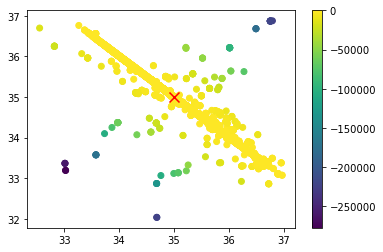

In [27]:
plt.figure()
plt.scatter(f['samples/mass1'], f['samples/mass2'], c=f['samples/loglikelihood'])
# plt.scatter(f['samples/mass1'], f['samples/mass2'], c=f['samples/loglr'])
plt.colorbar()

plt.scatter(static_params['mass1'], static_params['mass2'], marker='x', s=100, c='r')


plt.show()

In [47]:
type(f['samples/mass1'][:])

numpy.ndarray

array([33.94632324, 33.94632324, 33.94632324, ..., 36.07562307,
       36.07562307, 36.07562307])

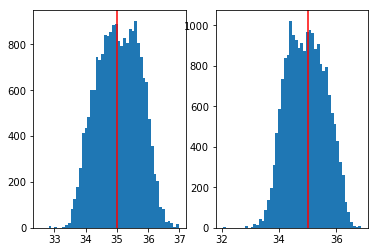

In [36]:
fig, axes = plt.subplots(1,2)
axes[0].hist(f['samples/mass1'][:].reshape(1000*20), bins=50);
axes[1].hist(f['samples/mass2'][:].reshape(1000*20), bins=50);
axes[0].axvline(static_params['mass1'], c='r')
axes[1].axvline(static_params['mass2'], c='r')

In [23]:
numpy.max(f['samples/loglr'])

133707.0696200431

In [24]:
numpy.sqrt(2*numpy.max(f['samples/loglr']))

517.1210102481683

In [25]:
numpy.max(f['samples/loglikelihood'])

-6.209447747096419e-06

In [26]:
numpy.min(f['samples/loglikelihood'])

-277700.04926100816

In [27]:
#rho_mf = sqrt(2 * loglr)

In [28]:
import pycbc.filter

In [29]:
signal

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x11ac3f790>}

In [30]:
snr = pycbc.filter.matched_filter(signal["H1"], signal["H1"], psd=psds["H1"],
                                      low_frequency_cutoff=40)




In [31]:
numpy.max(numpy.abs(snr.numpy()))

517.121010260176

In [32]:
snr.abs_max_loc()

(517.121010260176, 0)